# 5. 数据批次抽取分析

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

## 1. 数据读入

In [3]:
# 红系成熟部分
adata_filename = "./data/erythroid_lineage.h5ad"

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [4]:
adata_bak = adata.copy()

2. 构造待抽取的批次列表

In [5]:
import math

batch_list = list(adata_bak.obs[batch_key].cat.categories)
batch_list_list = []
for sep in range(1, math.ceil(len(batch_list)/2)):
# for sep in range(0, math.ceil(len(batch_list)/2)):
    batch_list_list.append(batch_list[::sep+1])

batch_list_list

[['E7.0', 'E7.5', 'E8.0', 'E8.5'], ['E7.0', 'E7.75', 'E8.5'], ['E7.0', 'E8.0']]

In [6]:
save = True # 控制保存路径

## 2. Velovgi执行

1. 批次抽取后执行所有流程

In [7]:
from pytorch_lightning import loggers

max_epochs = 500

adata_list = []
model_names = []

for tmp_batch_list in batch_list_list:
    name = "-".join(tmp_batch_list)
    model_names.append(name)
    print(name)

    # adata抽取
    adata = adata_bak[adata_bak.obs[batch_key].apply(lambda x:x in tmp_batch_list).astype(bool)].copy()
    print("adata", adata)

    # 预处理
    batch_pair_list = list(zip(tmp_batch_list[:-1], tmp_batch_list[1:])) # 构造临近批次对
    print("batch_pair_list", batch_pair_list)
    n_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

    # 开始训练
    seed_everything(seed) # 训练之前设置随机种子
    base_dir = "./batch_extract/%s"%name
    logger = loggers.TensorBoardLogger(save_dir="%s/log"%base_dir, name=name) # 构造日志文件
    velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
    velovgi_model = velovgi.tl.VELOVGI(subsample_adata)
    velovgi_model.train(logger=logger, max_epochs=max_epochs) # 训练
    
    # 结果恢复
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, velovgi_model) # 模型输出
    velovgi.pp.moment_recover(adata, subsample_adata) # 恢复

    # TODO:提取隐变量

    # 恢复
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding(adata, color=cluster_key, save="%s_velocity_embedding.png"%name, show=False)
    scv.pl.velocity_embedding_stream(adata, color=cluster_key, save="%s_velocity_embedding_stream.png"%name, show=False)

    # 模型保存
    if save == True:
        print("saving...")
        subsample_adata_dir = "%s/subsample_adata.h5ad"%base_dir
        subsample_adata.write(subsample_adata_dir)
        adata_dir = "%s/adata"%base_dir
        velovgi.tl.write_adata(adata, adata_dir)
        model_dir = "%s/model/%s"%(base_dir, name)
        velovgi_model.save(model_dir)
    
    adata_list.append(adata) # 方式adata拼接后后占用内存太大
    print("================================")

E7.0-E7.5-E8.0-E8.5
adata AnnData object with n_obs × n_vars = 311 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
batch_pair_list [('E7.0', 'E7.5'), ('E7.5', 'E8.0'), ('E8.0', 'E8.5')]
Filtered out 52178 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [('E7.0', 'E7.5'), ('E7.5', 'E8.0'), ('E8.0', 'E8.5')]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./batch_extract/E7.0-E7.5-E8.0-E8.5/log/E7.0-E7.5-E8.0-E8.5
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:04<00:00, 10.16it/s, loss=1.37e+04, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:04<00:00,  7.73it/s, loss=1.37e+04, v_num=0]
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/311 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E7.5-E8.0-E8.5_velocity_embedding.png
saving figure to file ./figures/scvelo_E7.0-E7.5-E8.0-E8.5_velocity_embedding_stream.png
saving...
create ./batch_extract/E7.0-E7.5-E8.0-E8.5/adata
save ./batch_extract/E7.0-E7.5-E8.0-E8.5/adata/sample_recover.pkl
save ./batch_extract/E7.0-E7.5-E8.0-E8.5/adata/adata.h5ad
E7.0-E7.75-E8.5
adata AnnData object with n_obs × n_vars = 212 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
batch_pair_list [('E7.0', 'E7.75'), ('E7.75', 'E8.5')]
Filtered out 52426 genes that are dete

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./batch_extract/E7.0-E7.75-E8.5/log/E7.0-E7.75-E8.5
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:53<00:00, 10.14it/s, loss=1.9e+04, v_num=0] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:53<00:00,  9.41it/s, loss=1.9e+04, v_num=0]
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/212 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E7.75-E8.5_velocity_embedding.png
saving figure to file ./figures/scvelo_E7.0-E7.75-E8.5_velocity_embedding_stream.png
saving...
create ./batch_extract/E7.0-E7.75-E8.5/adata
save ./batch_extract/E7.0-E7.75-E8.5/adata/sample_recover.pkl
save ./batch_extract/E7.0-E7.75-E8.5/adata/adata.h5ad
E7.0-E8.0
adata AnnData object with n_obs × n_vars = 161 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
batch_pair_list [('E7.0', 'E8.0')]
Filtered out 52804 genes that are detected 20 counts (shared).
Normalized count data

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./batch_extract/E7.0-E8.0/log/E7.0-E8.0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:51<00:00,  9.32it/s, loss=2.72e+03, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:51<00:00,  9.79it/s, loss=2.72e+03, v_num=0]
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/161 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E8.0_velocity_embedding.png
saving figure to file ./figures/scvelo_E7.0-E8.0_velocity_embedding_stream.png
saving...
create ./batch_extract/E7.0-E8.0/adata
save ./batch_extract/E7.0-E8.0/adata/sample_recover.pkl
save ./batch_extract/E7.0-E8.0/adata/adata.h5ad


2. 全数据集已经做过了，直接读取就行

In [8]:
model_names.append("-".join(batch_list))
adata_list.append(velovgi.tl.read_adata("./data/adata/"))

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


3. 指标计算

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"), 
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")
    ] # 已知的细胞类型间的分化信息

df_velovgi = velovgi.tl.get_metric_total_df(model_names, adata_list, cluster_edges, cluster_key) # 指标计算
df_velovgi.to_csv("./batch_extract/metric_df_velovgi.csv")
df_velovgi

,CBDir,Metric,Score,ICVCoh,Model
0,0.529076,CBDir,0.529076,NaN,E7.0-E7.5-E8.0-E8.5
1,-0.631308,CBDir,-0.631308,NaN,E7.0-E7.5-E8.0-E8.5
2,0.466323,CBDir,0.466323,NaN,E7.0-E7.5-E8.0-E8.5
3,0.293738,CBDir,0.293738,NaN,E7.0-E7.5-E8.0-E8.5
4,-0.970966,CBDir,-0.970966,NaN,E7.0-E7.5-E8.0-E8.5
...,...,...,...,...,...
495,NaN,ICVCoh,0.963388,0.963388,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
496,NaN,ICVCoh,0.939772,0.939772,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
497,NaN,ICVCoh,0.920894,0.920894,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
498,NaN,ICVCoh,0.924577,0.924577,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5


## 3. scvelo的批次抽取

In [16]:
batch_list_list.append(batch_list)

1. 执行

In [19]:
scvelo_adata_list = []
scvelo_model_names = []

for tmp_batch_list in batch_list_list:
    print("tmp_batch_list", tmp_batch_list)
    name = "-".join(tmp_batch_list)
    scvelo_model_names.append(name)
    
    # adata抽取
    adata = adata_bak[adata_bak.obs[batch_key].apply(lambda x:x in tmp_batch_list).astype(bool)].copy()
    print("adata", adata)

    # 预处理
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    # 速率估计
    scv.tl.velocity(adata)
    
    # 速率计算
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding(adata, color=cluster_key, save="%s_velocity_embedding_scvelo.png"%name, show=False)
    scv.pl.velocity_embedding(adata, color=cluster_key, save="%s_velocity_embedding_stream_scvelo.png"%name, show=False)
    
    base_dir = "./batch_extract/%s"%name
    adata_dir = "%s/adata_scvelo.h5ad"%base_dir
    adata.write(adata_dir)
    scvelo_adata_list.append(adata)

    print("================================")

tmp_batch_list ['E7.0', 'E7.5', 'E8.0', 'E8.5']
adata AnnData object with n_obs × n_vars = 311 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
Filtered out 52178 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (usin

/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/311 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E7.5-E8.0-E8.5_velocity_embedding_scvelo.png
saving figure to file ./figures/scvelo_E7.0-E7.5-E8.0-E8.5_velocity_embedding_stream_scvelo.png
tmp_batch_list ['E7.0', 'E7.75', 'E8.5']
adata AnnData object with n_obs × n_vars = 212 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
Filtered out 52426 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    fin

/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/212 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E7.75-E8.5_velocity_embedding_scvelo.png
saving figure to file ./figures/scvelo_E7.0-E7.75-E8.5_velocity_embedding_stream_scvelo.png
tmp_batch_list ['E7.0', 'E8.0']
adata AnnData object with n_obs × n_vars = 161 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
Filtered out 52804 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:00) -

/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/161 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E8.0_velocity_embedding_scvelo.png
saving figure to file ./figures/scvelo_E7.0-E8.0_velocity_embedding_stream_scvelo.png
tmp_batch_list ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
adata AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
Filtered out 51490 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    '

/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5_velocity_embedding_scvelo.png
saving figure to file ./figures/scvelo_E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5_velocity_embedding_stream_scvelo.png


2. 指标计算（在稍后的脚本中计算）

In [20]:
df_scvelo = velovgi.tl.get_metric_total_df(scvelo_model_names, scvelo_adata_list, cluster_edges, cluster_key) # 指标计算
df_scvelo.to_csv("./batch_extract/metric_df_scvelo.csv")
df_scvelo

,CBDir,Metric,Score,ICVCoh,Model
0,-0.551560,CBDir,-0.551560,NaN,E7.0-E7.5-E8.0-E8.5
1,-0.746856,CBDir,-0.746856,NaN,E7.0-E7.5-E8.0-E8.5
2,-0.626673,CBDir,-0.626673,NaN,E7.0-E7.5-E8.0-E8.5
3,-0.255662,CBDir,-0.255662,NaN,E7.0-E7.5-E8.0-E8.5
4,-0.904158,CBDir,-0.904158,NaN,E7.0-E7.5-E8.0-E8.5
...,...,...,...,...,...
495,NaN,ICVCoh,0.887949,0.887949,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
496,NaN,ICVCoh,0.796792,0.796792,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
497,NaN,ICVCoh,0.885725,0.885725,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
498,NaN,ICVCoh,0.729585,0.729585,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5


## 其他方法在多个批次上执行...

## 对比（在稍后的脚本中计算）

In [38]:
import pandas as pd
if "Dataset" not in df_velovgi.columns:
    df_velovgi["Dataset"] = df_velovgi["Model"]
    df_velovgi["Model"] = "velovgi"
if "Dataset" not in df_scvelo.columns:
    df_scvelo["Dataset"] = df_scvelo["Model"]
    df_scvelo["Model"] = "scvelo"

df = pd.concat([df_velovgi, df_scvelo])
df

,CBDir,Metric,Score,ICVCoh,Model,Dataset
0,0.529076,CBDir,0.529076,NaN,velovgi,E7.0-E7.5-E8.0-E8.5
1,-0.631308,CBDir,-0.631308,NaN,velovgi,E7.0-E7.5-E8.0-E8.5
2,0.466323,CBDir,0.466323,NaN,velovgi,E7.0-E7.5-E8.0-E8.5
3,0.293738,CBDir,0.293738,NaN,velovgi,E7.0-E7.5-E8.0-E8.5
4,-0.970966,CBDir,-0.970966,NaN,velovgi,E7.0-E7.5-E8.0-E8.5
...,...,...,...,...,...,...
495,NaN,ICVCoh,0.887949,0.887949,scvelo,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
496,NaN,ICVCoh,0.796792,0.796792,scvelo,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
497,NaN,ICVCoh,0.885725,0.885725,scvelo,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
498,NaN,ICVCoh,0.729585,0.729585,scvelo,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5


In [39]:
df["Dataset"].unique()

array(['E7.0-E7.5-E8.0-E8.5', 'E7.0-E7.75-E8.5', 'E7.0-E8.0',
       'E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5'], dtype=object)

In [40]:
name_dict = {
    "E7.0-E8.0":"E7.0-E8.0",
    "E7.0-E7.75-E8.5":"E7.0-E7.75-E8.5",
    "E7.0-E7.5-E8.0-E8.5":"E7.0-E7.5-E8.0\nE8.5",
    "E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5":"E7.0-E7.25-E7.5-\nE7.75-E8.0-E8.25-\nE8.5",
}
df["Dataset_bak"] = df["Dataset"]
df["Dataset"] = df["Dataset"].apply(lambda x: name_dict[x])
df["Dataset"] = df["Dataset"].astype("category")
df["Dataset"] = df["Dataset"].cat.set_categories(sorted(df["Dataset"].unique(), key=lambda x:len(x)))

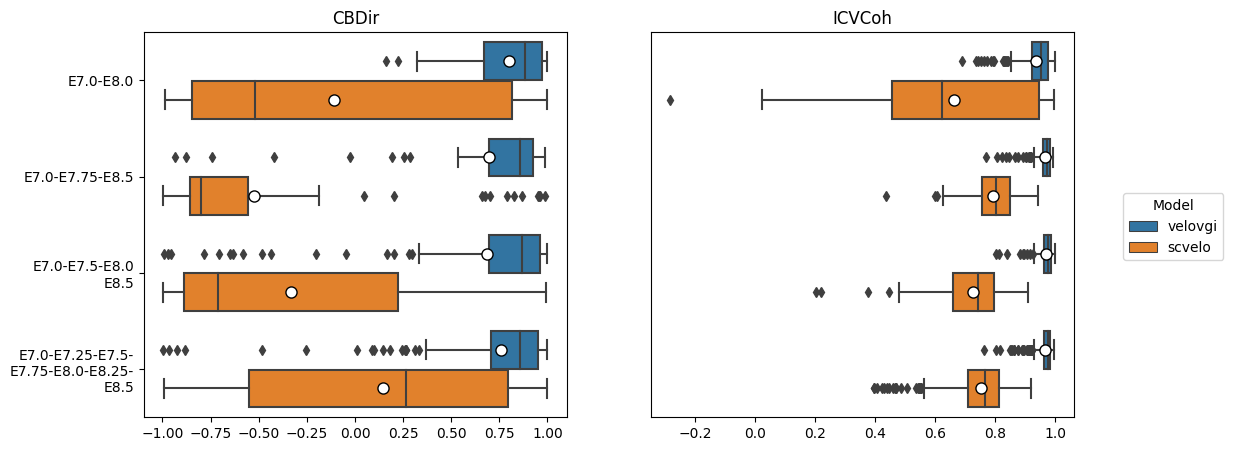

In [41]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(
    df.loc[df["Metric"].isin(["CBDir"])],
    orient="h", x="Score", y="Dataset", hue="Model", 
    ax=ax[0], showmeans=True,
    meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"8"})
ax[0].set_title("CBDir")
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].legend_.remove()

sns.boxplot(
    df.loc[df["Metric"].isin(["ICVCoh"])],
    orient="h", x="Score", y="Dataset", hue="Model", 
    ax=ax[1], showmeans=True,
    meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"8"})
ax[1].set_title("ICVCoh")
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1.1, 0.6)) # 移动图例(1,1)表示图形右上端